# Part 1

### Clustering

Clustering is a data mining technique that involves grouping a set of objects in such a way that objects in the same group (or cluster) are more similar to each other than to those in other groups. It's a method of unsupervised learning, and a common technique for statistical data analysis used in many fields. Algorithms like K-means are popular for clustering tasks.

**Strengths:**
- Can reveal natural groupings within data that may not be apparent initially, useful for market segmentation, social network analysis, etc.
- Algorithms like K-means are straightforward to implement and understand.
- Can be applied to data without any prior labeling, making it versatile for exploratory data analysis.

**Weaknesses:**
- For many algorithms, the number of clusters needs to be specified beforehand, which can be difficult without prior knowledge of the data.
- Some algorithms, like K-means, are sensitive to the initial placement of centroids, leading to potentially different outcomes on different runs.
- Many clustering algorithms make specific assumptions about the data (e.g., spherical clusters for K-means) which may not hold for all datasets, potentially leading to poor performance.

### Association

Association rule learning is a rule-based machine learning method for discovering interesting relations between variables in large databases. It's famous for market basket analysis where it finds sets of products that frequently co-occur in transactions. The Apriori algorithm is a well-known algorithm used to generate association rules.

**Strengths:**
- Effective at uncovering relationships between variables that are not readily apparent.
- The rules generated (e.g., "if A and B, then C") are straightforward for humans to understand and act upon, making them practical for decision-making processes.
- Can be applied to various types of data, including transactions, sequences, and texts.

**Weaknesses:**
- Can potentially generate a vast number of rules, many of which may be trivial or not useful, requiring further processing to find the most significant ones.
- The process can be computationally expensive, especially with large datasets and numerous itemsets.
- Traditional association rule learning methods are best suited for categorical data and might not directly apply to continuous variables without discretization.

### Correlation Analysis

Correlation analysis measures the statistical relationship between two variables, determining how one variable changes in relation to the other. Techniques such as Pearson's correlation, Spearman's rank correlation, and Kendall's tau are used to quantify the degree of correlation between variables.

**Strengths:**
- Provides a quantitative measure of the strength and direction of the linear relationship between two variables.
- Correlation coefficients are easy to calculate and interpret, making them accessible for many users.
- Useful as a preliminary step to more complex analyses, helping to identify potential predictors for modeling.

**Weaknesses:**
- Standard correlation coefficients only measure linear relationships, potentially missing nonlinear associations.
- A common misconception is to interpret correlation as causation, which can lead to incorrect conclusions about the relationship between variables.
- Correlation can be significantly affected by outliers, leading to misleading correlation measures unless the data is carefully preprocessed.


# Part 2

## K- Means Clustering

### Packages

Here is all of the packages we used

In [64]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
from IPython.display import display
from sklearn.datasets import make_blobs
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score


### Load the data

We used pandas to read a csv file 

In [65]:

# Load the dataset
df = pd.read_csv('diabetic_data.csv')

# Drop identifier columns
identifier_columns = ['admission_type_id', 'discharge_disposition_id', 'max_glu_serum', 'A1Cresult', 'admission_source_id', 'encounter_id', 'patient_nbr', 'payer_code', 'medical_specialty', 'weight', 'diag_1', 'diag_2', 'diag_3', 'gender', 'age', 'race']
df.drop(identifier_columns, axis=1, inplace=True)

# Impute missing values for numerical columns
imputer = SimpleImputer(strategy='mean')
numerical_cols = ['num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])


### Preprocessing

In order to be able to run the clustering algorithm, we had to do numerous of conversions and features. 

Scaling Numerical Features- Since clustering algorithms use distance measures to assign clusters, we need to scale them so that they have a mean of 0 and a standard deviation of 1

Identifying Non-Numeric Columns- K-means cannot handle categorical variables so we need to convert these. 

One-Hot-Encoding- Convert categorical variables to binary so that k-means interpets them correctly

Transforming Encoded data to Dense Array- not all libraries can handle sparse matrices

Dropping oringial Non- Numeric columns- We already have the revised version. 

In [66]:

# Scale numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns

# Apply One-Hot Encoding to non-numeric columns
encoder = OneHotEncoder()
# Fit and transform the data and convert it to a dense array
encoded_columns = encoder.fit_transform(df[non_numeric_columns]).toarray()
# Create a DataFrame with the encoded variables
df_encoded = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(non_numeric_columns))

# Drop the original non-numeric columns from df
df.drop(non_numeric_columns, axis=1, inplace=True)

# Concatenate the original df with the encoded DataFrame
df = pd.concat([df, df_encoded], axis=1)

# Now your dataframe should have only numeric values and is ready for clustering
# Ensure to reset index if necessary
df.reset_index(drop=True, inplace=True)

df.head()
# Continue with the elbow method as before
# The rest of the code remains the same
# Assuming the initial steps are done and df is your preprocessed dataframe


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin_Down,metformin_No,...,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
0,1,-0.106517,-0.785398,-1.848268,-0.291461,-0.21262,-0.503276,1,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,3,0.808384,-0.785398,0.243390,-0.291461,-0.21262,-0.503276,9,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2,-1.631351,2.145781,-0.371804,1.286748,-0.21262,0.288579,6,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,2,0.045967,-0.199162,-0.002688,-0.291461,-0.21262,-0.503276,7,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,0.401761,-0.785398,-0.986997,-0.291461,-0.21262,-0.503276,5,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


### Elbow Method

The elbow method can determine the number of clusters in a data set. It plots a function of the number of clusters, and the optimial amount of clusters is at the bend or elbow of the curve. 

C:\Users\jacku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jacku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jacku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

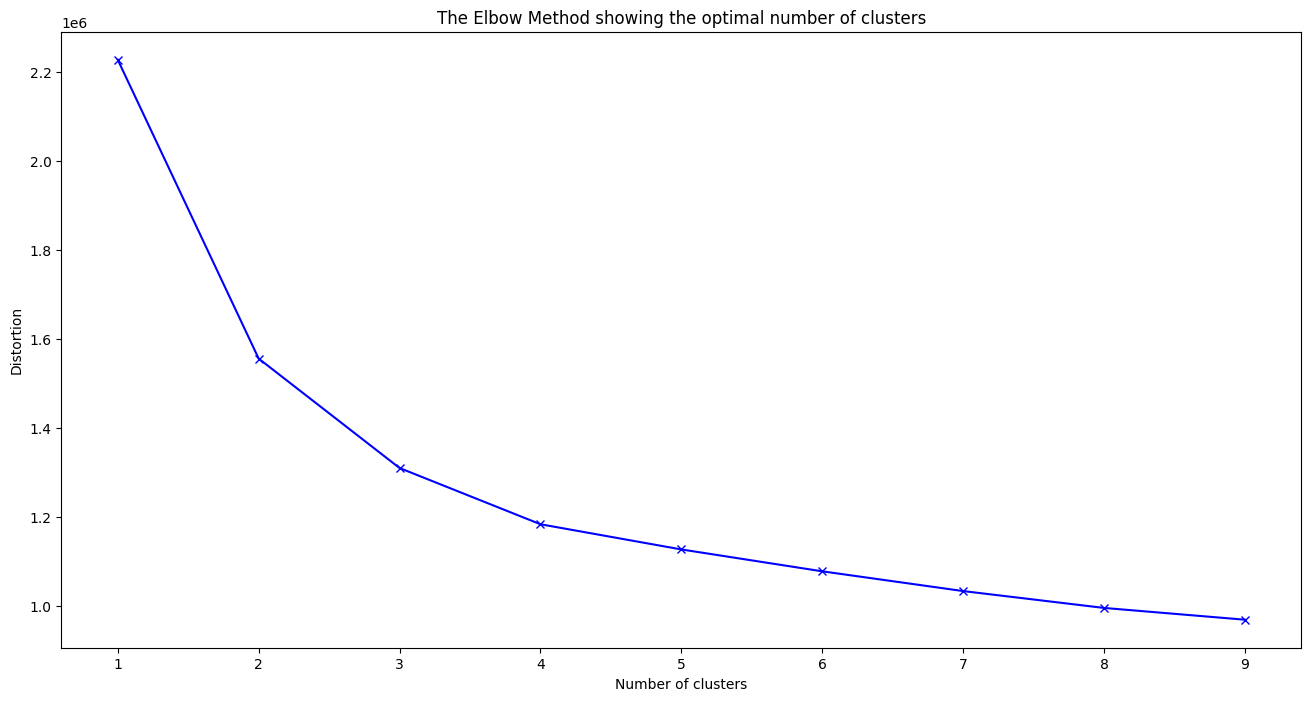

In [67]:

# Determine the optimal number of clusters using the elbow method
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

# Plotting the distortions to find the elbow
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()



### Build and Running the Clustering Modle

Standard code to build and run the model. No testing is needed because this is an unsupervised technqiue. We two three clusters because that was the point where the rate of decrease of the within cluster sum of squares- WCSS- starts to slow down (no longer steep).

Typically points after the elbow will have diminishing returns as the complexity of the model and the gain in a better fit becomes unfavorable. 

In [68]:

# Instantiate the KMeans model with the desired number of clusters
kmeans = KMeans(n_clusters=2, random_state=42)  # You can adjust the number of clusters as needed

# Fit the model to the data
kmeans.fit(df)

# Assign cluster labels to the data points
cluster_labels = kmeans.labels_

# Add cluster labels to the DataFrame
df['cluster'] = cluster_labels

# Now you can analyze the clusters and their characteristics
# For example, you can check the distribution of data points in each cluster
cluster_distribution = df['cluster'].value_counts()
print("Cluster distribution:")
print(cluster_distribution)

# You can also analyze cluster centroids to understand the characteristics of each cluster
cluster_centroids = kmeans.cluster_centers_
print("\nCluster centroids:")
print(cluster_centroids)

C:\Users\jacku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster distribution:
cluster
1    74207
0    27559
Name: count, dtype: int64

Cluster centroids:
[[ 8.44650825e+00  4.61736861e-01  3.30948971e-01  7.00460555e-01
  -8.16815496e-03 -6.71993522e-03  1.08203242e-01  8.14398694e+00
   7.21929984e-03  8.14220932e-01  1.63758389e-01  1.48013786e-02
   9.06947216e-04  9.77761654e-01  1.89370579e-02  2.39434065e-03
   2.53945220e-04  9.92417921e-01  6.96535462e-03  3.62778886e-04
   8.48727013e-19  9.99129331e-01  7.98113550e-04  7.25557773e-05
   3.51895520e-03  9.44930165e-01  4.58552512e-02  5.69562851e-03
   9.99963722e-01  3.62778886e-05  9.14202793e-03  8.69798658e-01
   1.07672773e-01  1.33865409e-02  9.32341738e-03  8.85906040e-01
   9.14928351e-02  1.32777072e-02  9.99673499e-01  3.26500998e-04
   2.03156176e-03  9.25811718e-01  6.73317613e-02  4.82495919e-03
   1.23344821e-03  9.37202975e-01  5.82622891e-02  3.30128787e-03
   3.62778886e-05  9.96952657e-01  2.82967531e-03  1.81389443e-04
  -3.15773883e-18  9.99637221e-01  3.2650099

### Visualizing the Results

Here is a dynamic graph in which the user can choose the number of clusters.

In [69]:
# Convert the DataFrame to a NumPy array for K-Means
X = df.values  # This converts the DataFrame to a NumPy array

def plot_kmeans(k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(X)
    
    # Since PCA is not performed here, we can't plot the high-dimensional data directly.
    # Perform PCA for 2D visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
    centers = kmeans.cluster_centers_
    # Transform the centers back to the original space for plotting
    centers_pca = pca.transform(centers)
    plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.5)
    plt.title(f"K-means Clustering with k={k}")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

interact(plot_kmeans, k=IntSlider(min=1, max=10, step=1, value=3))

interactive(children=(IntSlider(value=3, description='k', max=10, min=1), Output()), _dom_classes=('widget-int…

<function __main__.plot_kmeans(k)>

## Analyzing the Model

### Silhouette Socre

This evaluation score measures how similar an object is to its own cluster compared to the other clusters. Allows for evaluation of clustering performance.

Close to 1- Sample is far away from the neighboring clusters which means that hte point is well clustered

Close to 0- Sample is close to the decision boundary between two neighboring clusters (can be assigned to either cluster)

Close to (-1)- Sample is assigned to wrong cluster, indicating that the point is poorly clustered

2 Clusters gives the best score

In [70]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(X, cluster_labels)
print('The average silhouette_score is :', silhouette_avg)


The average silhouette_score is : 0.3140946627795024


### Davies-Bouldin Index

This metric evaluates clustering algorithms. It measures the Within-Cluster Scatter and Between-Cluster Seperation. 

Within Cluster Scatter- Average distance between each point in the cluster and the centriod

Between Cluster Seperation- Distance between the centroids of the clusters.

Lower Number- This is what we are looking for. A lower DBI means that the average cluster is further away from its most similar cluster. (0 is a fully distinct cluster)


In [71]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X, cluster_labels)
print('Davies-Bouldin Index:', db_index)

Davies-Bouldin Index: 1.280292578753313


### Interpreting the Results

The visual representation shows the data points in the graph. It appears that the clusters are somewhat distinct, but seems to overlap/stretch out. Ideally we want the cluster more compact and seperates, but increasing the number of cluster decreased the silhouette score. 

Silhouette Score- The clusters are weakly distinguished (.5 are generally better). Once we increase the number of clusters, this metric becomes worse.

Davies-Bouldin Index- This relatively high DBI suggests there is room for improvement. It means that the clusters have some overlap and are not well-separeted.

Increasing the number of clusters seems to worsen these metrics.
Silhouette Score (2 Clusters) .314 --> (3 Clusters) .4
Davies-Bouldin Index (2 Clusters) 1.28 --> (3 Clusters) 1.40


### Conclusion

Although the clustering was not optimal, this might lead to some insights about the data. Our data seems to lack clear seperation between clusters.

The diabetic data seems to be too complex for K-means clustering. More advanced clustering techniques may capture patterns more effectively. Hierarchical clustering may reveal more meaningful grouping within the data. 

## Associtive Rule Mining

### Reading in the Dataset

Preprocessing Looks different from model to model, so we are going to start over. Here we loaded in the dataset.

In [72]:
# Load the dataset
df = pd.read_csv('diabetic_data.csv')

# Define the medication columns that you want to keep
medication_columns = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone',
    'change', 'diabetesMed', 'readmitted'
]

# Keep only the medication columns in the dataframe
df = df.loc[:, medication_columns]

# Keep only the medication columns in the dataframe
df = df.loc[:, medication_columns]



### Preprocessing

We needed to convert non boolean colums to boolean (Everything need to  be in a similar format)

In [73]:

# Convert non-boolean columns to boolean:
# Convert the strings 'No' to 0 and any other value to 1
df_binary = df.applymap(lambda x: 0 if x == 'No' else 1)

df_binary.head()


C:\Users\jacku\AppData\Local\Temp\ipykernel_22456\4103278918.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_binary = df.applymap(lambda x: 0 if x == 'No' else 1)


,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,1
4,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,1,1


### Building and Running the model

In [74]:
# Perform Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df_binary, min_support=0.01, use_colnames=True)

# Generate the rules with their corresponding support, confidence and lift
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.1)


C:\Users\jacku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


### Evaluating the Model 

Here we are going to Evaluate the model qauntitatively by print out the rules or metrics.

In [75]:

# Display the first few rules
print(rules.head())

     antecedents  consequents  antecedent support  consequent support  \
0  (glimepiride)  (metformin)            0.051009            0.196411   
1    (glipizide)  (metformin)            0.124659            0.196411   
2    (metformin)  (glipizide)            0.196411            0.124659   
3    (metformin)  (glyburide)            0.196411            0.104652   
4    (glyburide)  (metformin)            0.104652            0.196411   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.013649    0.267579  1.362337  0.003630    1.097167       0.280263  
1  0.034776    0.278969  1.420330  0.010292    1.114499       0.338083  
2  0.034776    0.177056  1.420330  0.010292    1.063671       0.368271  
3  0.037537    0.191115  1.826195  0.016982    1.106891       0.562991  
4  0.037537    0.358685  1.826195  0.016982    1.253034       0.505293  


### Visualizing the Results

Plotting the Association Rules Support vs Confidence

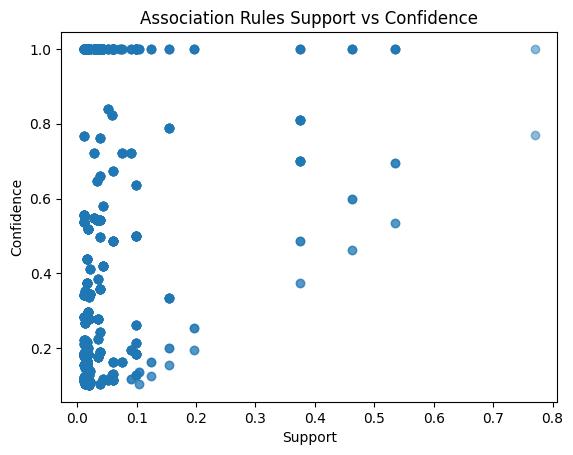

In [76]:
# Assuming 'rules' is a DataFrame containing the association rules and their metrics
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.title('Association Rules Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()



### Interpreting the Results

Graph- There a dense cluster of point with low support which means the rules are not common and have varing results. Points with higher support and high confidence- strongest rules and most reliable. Rules with high confidence but lower support mean they have a strong preditive power when antecdent is present (not common throughout the dataset though).

Support: This is the proportion of transactions in the data. 

Confidence: Metric that gives probability of seeing the consequent in transactions given the antecedent. There is a 26.7579% chance of metformin being present when glimepiride is present.

Lift: Measures how much more often the antecedent and consequent occur together than expected if they were independent. Value greater than 1 means that a positive association. Ex- Positive relationship between glimepiride and metformin.

Leverage: Difference in probability of antecedent and consequent appearing together than expected if they were independent. Positive leverage indicates a positive association. 

Conviction: Measures the degree of implication of a rule. High conviction means consequent is highly dependent on the antecedent. Glimepiride is dependent on metformin. 

Zhang's metric: Measures rules strength and direction. 1 means that always occur together and -1 means that they never. Metformin and glyburide usually occur together. 

### Conclusion

Associtive Rule Mining gives us interesting insights into the diabetic data. 

Most Related rules are as follows:
(metformin) -> (glyburide) - Lift 1.83, Confidence .19
(glyburide) -> (metformin) - Lift 1.83, Confidence .36

It seems as if these medicines are closely related and commonly used together.

Least Related rules:
(glimepiride) -> (metformin)- Lift 1.36, Confidence .268
(metformin) -> (glipizide)- Lift of 1.42, Confidence of .177

(metformin) -> (glipizide) is the weakest association


### Refrences

Smith, J. (Year). Association rule mining on big data sets. In S. Brown (Ed.), Data mining in large sets of complex data (pp. 50-75). IntechOpen. 

Johnson, A. (Year). Association rule mining explained with examples. Coding Infinite. https://www.codinginfinite.com/association-rule-mining-explained-with-examples/

Isac Artzi, Geek For Geeks, Stack Overflow, and OpenAI.